# Long-slit spectroscopy in the L-band of three models of a young stellar object

This notebook presents METIS LSS L-band simulation of three models of a young stellar object (YSO).

In [1]:
import scopesim as sim
sim.bug_report()

# Edit this path if you have a custom install directory, otherwise comment it out. [For ReadTheDocs only]
#sim.rc.__config__["!SIM.file.local_packages_path"] = "../../../"

Python:
3.11.4 | packaged by Anaconda, Inc. | (main, Jul  5 2023, 13:38:37) [MSC v.1916 64 bit (AMD64)]

Installed Python packages:
           anisocado: 0.3.0
         astar-utils: 0.2.3a0
             astropy: 5.3.4
      beautifulsoup4: 4.12.2
            docutils: 0.19
               httpx: 0.23.3
                lxml: 4.9.4
          matplotlib: 3.8.0
      more-itertools: 10.1.0
               numpy: 1.26.3
               pooch: 1.7.0
              pyyaml: 6.0.1
               scipy: 1.11.4
            scopesim: 0.8.2
       scopesim_data: could not be loaded.
  scopesim_templates: 0.5.1
         skycalc_ipy: 0.4.0
             synphot: 1.2.1
                tqdm: 4.66.1

Installed IRDB packages:

Operating System info:
   System: Windows
  Release: 10
  Version: 10.0.22631
  Machine: AMD64


In [2]:
import numpy as np

from astropy.io import fits
from astropy import units as u

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

If you haven't got the instrument packages yet, uncomment the following cell, which will install the packages into `./inst_pkgs`, a subdirectory of your current working directory. This is the default location where scopesim looks for instrument packages.

In [8]:
#sim.download_packages(["METIS", "ELT"], release="2024-02-29")
sim.download_packages(["Armazones"])

astar.scopesim.server.database - Gathering information from server ...
astar.scopesim.server.database - Connection successful, starting download ...


Extracting  Armazones: 100%|█████████████████████████████████████████████| 10/10 [00:00<00:00, 1194.04it/s]            


[WindowsPath('C:/Users/ghost/Desktop/PhD/irdb/METIS/docs/example_notebooks/inst_pkgs/Armazones.zip')]

If you have downloaded the packages but to a different location, you can set
```python
sim.rc.__config__["!SIM.file.local_packages_path"] = <"/path/to/inst/pkgs">
```
We recommend, however, to create a working directory for each simulation project and to use the default installation of packages into a subdirectory. Keeping simulation results and configuration files together that way makes it easy to reconstruct later the exact conditions under which a simulation was run.

# Preparation of source cubes

The input data are cubes of three different models of the same YSO, HD100546. We keep the names of FITS files, the `Source` objects and the results of the Scopesim simulations in dictionaries, indexed by short names for the models.

In [9]:
fitsfiles = {}
fitsfiles['cav'] = "models_Lband_HD100546_cav_f100PAH.cube_3.0mas.fits"
fitsfiles['emptycav'] = "models_Lband_HD100546_empytcav.cube_3.0mas.fits"
fitsfiles['gap'] = "models_Lband_HD100546_gap100.cube_3.0mas.fits"
models = list(fitsfiles.keys())
print("Model names:", models)

Model names: ['cav', 'emptycav', 'gap']


The FITS files can be downloaded from the Scopesim server. If you already have them, make sure that the files are in the current working directory.

In [10]:
sim.download_example_data(list(fitsfiles.values()))

[WindowsPath('C:/Users/ghost/Desktop/PhD/irdb/METIS/docs/example_notebooks/models_Lband_HD100546_cav_f100PAH.cube_3.0mas.fits'),
 WindowsPath('C:/Users/ghost/Desktop/PhD/irdb/METIS/docs/example_notebooks/models_Lband_HD100546_empytcav.cube_3.0mas.fits'),
 WindowsPath('C:/Users/ghost/Desktop/PhD/irdb/METIS/docs/example_notebooks/models_Lband_HD100546_gap100.cube_3.0mas.fits')]

The file headers are not yet in the form that Scopesim understands and we make two minor modifications: 
- Set CRVAL to 0, because Scopesim cannot look elsewhere
- Set BUNIT keyword (files have UNITS, which is non-standard)
- The cubes contain the occasional negative value. We replace these with 0.
- We introduce a factor `scale_delt` to increase the pixel size, which makes features more visible. If you want to simulate the original source pixel scale, set `scale_delt` to 1.

In [11]:
sources = {}
scale_cdelt = 1
for model, fitsfile in fitsfiles.items():
    with fits.open(fitsfile) as hdul:
        hdul[0].header['CRVAL1'] = 0.
        hdul[0].header['CRVAL2'] = 0.
        hdul[0].header['CDELT1'] *= scale_cdelt
        hdul[0].header['CDELT2'] *= scale_cdelt
        hdul[0].header['BUNIT'] = hdul[0].header['UNITS']
        hdul[0].data[hdul[0].data < 0] = 0
        sources[model] = sim.Source(cube=hdul)

To get an impression of what the data look like we display the cubes summed along the wavelength direction.

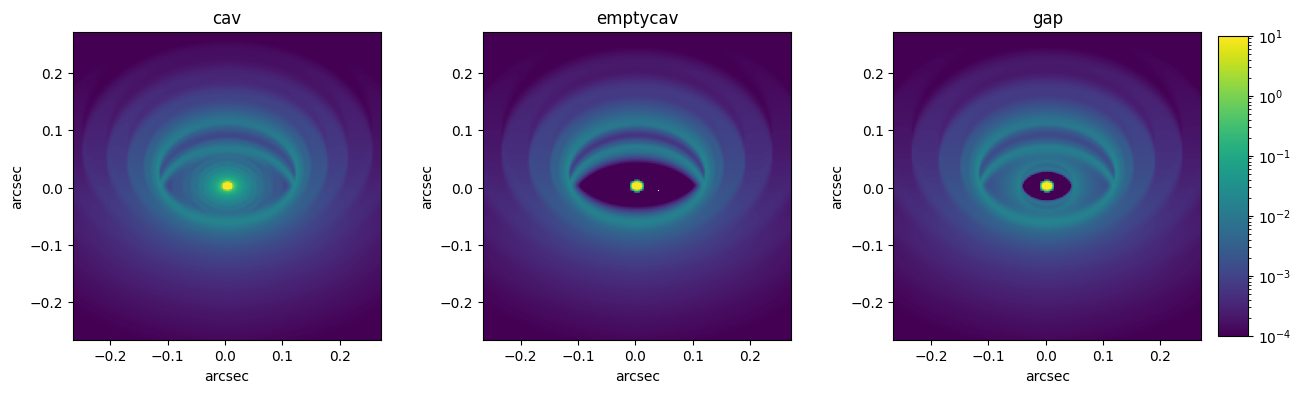

In [12]:
# Determine plot limits in arcsec from header keywords
hdr = sources['cav'].cube_fields[0].header
i_lim = np.array([0, hdr['NAXIS1']])
x_lim = hdr['CRVAL1'] + hdr['CDELT1'] * (i_lim + 1 - hdr['CRPIX1']) * 3600
j_lim = np.array([0, hdr['NAXIS2']])
y_lim = hdr['CRVAL2'] + hdr['CDELT2'] * (j_lim + 1 - hdr['CRPIX2']) * 3600

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
for i, (model, src) in enumerate(sources.items()):
    im = axes[i].imshow(src.cube_fields[0].data.sum(axis=0) + 1e-14,   # add small positive value to avoid 0 in LogNorm
                        origin='lower', norm=LogNorm(vmin=1e-4, vmax=10),
                        extent=(x_lim[0], x_lim[-1], y_lim[0], y_lim[-1]))
    axes[i].set_xlabel("arcsec")
    axes[i].set_ylabel("arcsec")
    axes[i].set_title(model);
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.9, 0.12, 0.02, 0.75])
fig.colorbar(im, cax=cbar_ax);

In wavelength, the cubes are sampled on a linear wavelength grid from 3.1 to 4 $\mu\mathrm{m}$, with a step size of $0.2\,\mu\mathrm{m}$:

In [13]:
sources['cav'].cube_fields[0].wave

<Quantity [3.1 , 3.12, 3.14, 3.16, 3.18, 3.2 , 3.22, 3.24, 3.26, 3.28,
           3.3 , 3.32, 3.34, 3.36, 3.38, 3.4 , 3.42, 3.44, 3.46, 3.48,
           3.5 , 3.52, 3.54, 3.56, 3.58, 3.6 , 3.62, 3.64, 3.66, 3.68,
           3.7 , 3.72, 3.74, 3.76, 3.78, 3.8 , 3.82, 3.84, 3.86, 3.88,
           3.9 , 3.92, 3.94, 3.96, 3.98, 4.  ] um>

# Simulation with Scopesim

The cubes are observed in the long-slit spectroscopic mode in the L band. As usual, there are four steps: `UserCommands` -> `OpticalTrain` -> `observe` -> `readout` to arrive at a detector image. The optical train can be reused for observation of different source when `update=True` is set in `observe()`. 

In [14]:
exptime = 3600.   # seconds
cmd = sim.UserCommands(use_instrument="METIS", set_modes=["lss_l"],
                      properties={"!OBS.exptime": exptime,
                                 "!SIM.spectral.spectral_resolution": 20000,
                                 "!SIM.spectral.spectral_bin_width": 2e-4})

In [15]:
metis = sim.OpticalTrain(cmd)

In [16]:
results = {}
for model, src in sources.items():
    print(f'Observing model "{model}..."')
    metis.observe(src, update=True)
    results[model] = metis.readout(detector_readout_mode='auto')[0]
    print("-----")

Observing model "cav..."


 FOVs:   0%|                                                                                     | 0/1 [00:00<?, ?it/s]

astar.scopesim.optics.image_plane_utils - WARNING: Non-linear WCS rescaled using linear procedure.



 FOV effects:  50%|███████████████████████████████████                                   | 1/2 [00:26<00:26, 26.49s/it]

astar.scopesim.effects.spectral_trace_list_utils - Mapping METIS LSS L



 FOVs: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:36<00:00, 36.82s/it]
 Image Plane effects: 0it [00:00, ?it/s]

astar.scopesim.effects.electronic - Detector mode set to fast
astar.scopesim.detector.detector_array - Extracting from 1 detectors...


astar.scopesim.effects.electronic - Detector mode set to fast
-----
Observing model "emptycav..."


 FOVs:   0%|                                                                                     | 0/1 [00:00<?, ?it/s]

astar.scopesim.optics.image_plane_utils - WARNING: Non-linear WCS rescaled using linear procedure.



 FOV effects:  50%|███████████████████████████████████                                   | 1/2 [00:05<00:05,  5.59s/it]

astar.scopesim.effects.spectral_trace_list_utils - Mapping METIS LSS L



 FOVs: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.56s/it]
 Image Plane effects: 0it [00:00, ?it/s]

astar.scopesim.effects.electronic - Detector mode set to fast
astar.scopesim.detector.detector_array - Extracting from 1 detectors...


astar.scopesim.effects.electronic - Detector mode set to fast
-----
Observing model "gap..."


 FOVs:   0%|                                                                                     | 0/1 [00:00<?, ?it/s]

astar.scopesim.optics.image_plane_utils - WARNING: Non-linear WCS rescaled using linear procedure.



 FOV effects:  50%|███████████████████████████████████                                   | 1/2 [00:05<00:05,  5.78s/it]

astar.scopesim.effects.spectral_trace_list_utils - Mapping METIS LSS L



 FOVs: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.82s/it]
 Image Plane effects: 0it [00:00, ?it/s]

astar.scopesim.effects.electronic - Detector mode set to fast
astar.scopesim.detector.detector_array - Extracting from 1 detectors...


astar.scopesim.effects.electronic - Detector mode set to fast
-----


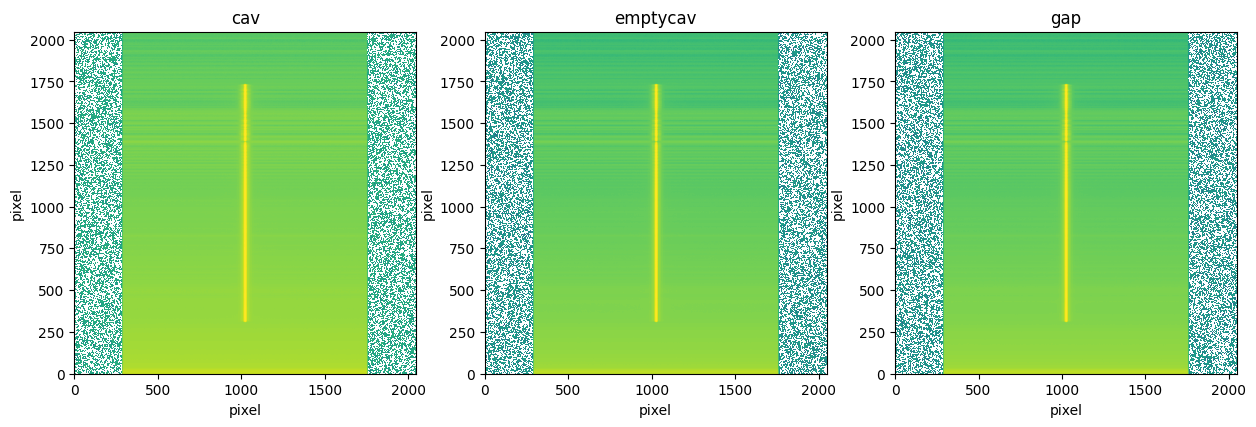

In [17]:
plt.figure(figsize=(15, 5))
for i, (model, result) in enumerate(results.items()):
    plt.subplot(1, 3, i+1)
    plt.imshow(result[1].data, origin='lower', norm=LogNorm())
    plt.xlabel("pixel")
    plt.ylabel("pixel")
    plt.title(model);

The following is a simulation of a blank-sky observation, which will be used for background subtraction. Given that the source is fairly compact, one could estimate the background from the science observation as well.

In [18]:
sky = sim.source.source_templates.empty_sky()
metis.observe(sky, update=True)
bgresult = metis.readout(detector_readout_mode="auto")[0]

 FOV effects:  50%|███████████████████████████████████                                   | 1/2 [00:05<00:05,  5.88s/it]

astar.scopesim.effects.spectral_trace_list_utils - Mapping METIS LSS L



 FOVs: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.36s/it]
 Image Plane effects: 0it [00:00, ?it/s]

astar.scopesim.effects.electronic - Detector mode set to slow
astar.scopesim.effects.electronic - WARNING: DIT = 1.000 s < MINDIT = 1.300 s
astar.scopesim.detector.detector_array - Extracting from 1 detectors...


astar.scopesim.effects.electronic - Detector mode set to slow
astar.scopesim.effects.electronic - WARNING: DIT = 1.000 s < MINDIT = 1.300 s


Before showing the background subtracted spectra, we convert the pixel numbers to wavelength and spatial position along the slit. This is possible because the current version of Scopesim/METIS by default uses perfectly linear mapping of the spectra onto the detector. The WCS keywords to use are in `metis['spectral_traces'].meta`. The plots will be restricted to the area covered by the spectra.

In [19]:
meta = metis['spectral_traces'].meta

det_xi = meta['CRVAL1'] + meta['CDELT1'] * (np.arange(2048) + 1 - meta['CRPIX1'])  * u.Unit(meta['CUNIT1'])
det_xi = det_xi.to(u.arcsec)

det_wave = (meta['CRVAL2'] + meta['CDELT2'] * (np.arange(2048) + 1 - meta['CRPIX2'])) * u.Unit(meta['CUNIT2'])
det_wave = det_wave.to(u.um)

In [21]:
det_xi

<Quantity [-5.59581, -5.59034, -5.58487, ...,  5.59034,  5.59581,  5.60128] arcsec>

In [22]:
det_wave

<Quantity [4.199605, 4.19897 , 4.198335, ..., 2.90103 , 2.900395, 2.89976 ] um>

In [23]:
ilim = np.array([750, 1300])    # pixels along spatial direction
jlim = np.array([300, 1750])    # pixels along wavelength direction
xlim = det_xi[ilim].value
ylim = det_wave[jlim].value

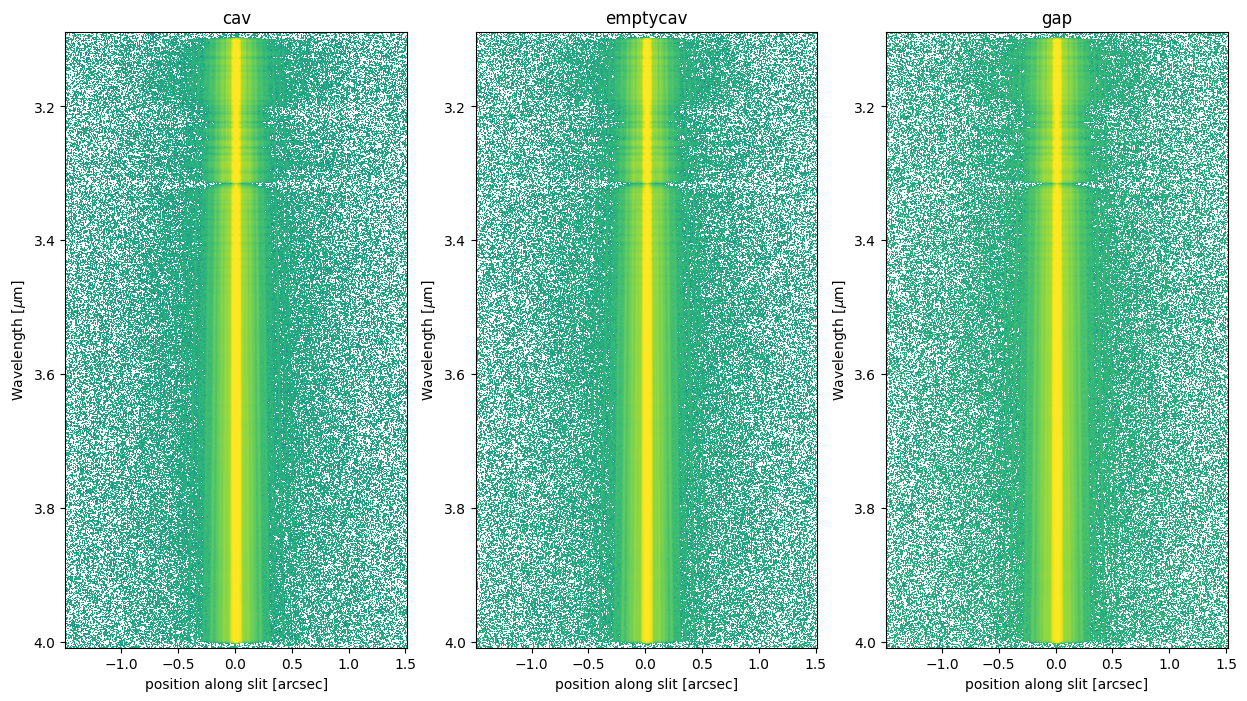

In [24]:
plt.figure(figsize=(15, 8))
for i, (model, result) in enumerate(results.items()):
    plt.subplot(1, 3, i+1)
    plt.imshow((result[1].data - bgresult[1].data)[jlim[0]:jlim[1], ilim[0]:ilim[1]], origin='lower', norm=LogNorm(),
               extent=(xlim[0], xlim[1], ylim[0], ylim[1]), aspect='auto')
    plt.xlabel(r"position along slit [arcsec]")
    plt.ylabel(r"Wavelength [$\mu$m]")
    plt.title(model);

The results have to be saved to disk explicitely so they can be analysed with external tools. 

In [ ]:
from pathlib import Path
for i, (model, result) in enumerate(results.items()):
    outfile = Path(fitsfiles[model]).stem + "-simulated_LSS_L" + Path(fitsfiles[model]).suffix
    result.writeto(outfile, overwrite=True)
    print(fitsfiles[model], "--->", outfile)
bgresult.writeto("models_Lband_HD100546-background_simulated_LSS_L.fits", overwrite=True)

# Note on the spectral mapping
To use the true spectral mapping of METIS, the trace file has to be set before building the optical train, for example by setting `"!OBS.trace_file"` in the `UserCommands`:  
```python
cmd = sim.UserCommands(use_instrument="METIS", set_modes=["lss_l"],
                      properties={"!OBS.exptime": 3600,
                                  "!OBS.trace_file": "TRACE_LSS_L.fits"})
```
For the METIS long-slit mode, the non-linear parts of the actual mapping are quite small.  

# Rotating the field
In Scopesim, the METIS slit is always aligned with the x-axis. To simulate different slit orientations, the input cube has to be rotated. We define a function to do this (for more explanation of the steps see the notebook `LSS_AGN-01_preparation.ipynb`).

In [25]:
from astropy.wcs import WCS
from scipy.interpolate import RectBivariateSpline

In [26]:
def rotate_cube(incube, angle):
    """Rotate input cube by angle
    
    Parameters
    ----------
    incube : ImageHDU
    angle : float
        angle in degrees, counterclockwise from positive x-axis
    """
    rangle = angle * np.pi / 180     # degrees to radians
    
    wcs_orig = WCS(incube.header).sub(2)
    wcs_orig.wcs.ctype = ["LINEAR", "LINEAR"]   # avoids discontinuity around RA=0 degrees
    wcs_rot = WCS(incube.header).sub(2)
    wcs_rot.wcs.ctype = ["LINEAR", "LINEAR"]
    
    wcs_rot.wcs.pc = [[np.cos(rangle), np.sin(rangle)],
                     [-np.sin(rangle), np.cos(rangle)]]
    i_orig = np.arange(incube.header['NAXIS1'])
    j_orig = np.arange(incube.header['NAXIS2'])
    x_orig, y_orig = wcs_orig.all_pix2world(i_orig, j_orig, 0)
    x_orig[x_orig >180] -= 360.     # RA continuous across 0
    i_rot, j_rot = np.meshgrid(i_orig, j_orig)
    x_rot, y_rot = wcs_rot.all_pix2world(i_rot, j_rot, 0)
    
    for iplane, plane in enumerate(incube.data):
        interp = RectBivariateSpline(y_orig, x_orig, plane, kx=1, ky=1)
        incube.data[iplane,] = interp(y_rot, x_rot, grid=False)
    incube.header['ANGLE'] = angle, "slit rotation [deg]"
    return incube

The function is applied to the data cubes before creating the `Source` object. We choose an angle of 45 degrees. The simulation the proceeds as above.

In [27]:
angle = 45
rotsources = {}
for model, fitsfile in fitsfiles.items():
    with fits.open(fitsfile) as hdul:     
        hdul[0].header['CRVAL1'] = 0.
        hdul[0].header['CRVAL2'] = 0.
        hdul[0].header['CDELT1'] *= scale_cdelt
        hdul[0].header['CDELT2'] *= scale_cdelt
        hdul[0].header['BUNIT'] = hdul[0].header['UNITS']
        hdul[0].data[hdul[0].data < 0] = 0
        hdul[0] = rotate_cube(hdul[0], angle)
        rotsources[model] = sim.Source(cube=hdul)

In [28]:
rotresults = {}
for model, src in rotsources.items():
    print(f'Observing model "{model}"...')
    metis.observe(src, update=True)
    rotresults[model] = metis.readout(detector_readout_mode='auto')[0]
    print("-----")

Observing model "cav"...


 FOVs:   0%|                                                                                     | 0/1 [00:00<?, ?it/s]

astar.scopesim.optics.image_plane_utils - WARNING: Non-linear WCS rescaled using linear procedure.



 FOV effects:  50%|███████████████████████████████████                                   | 1/2 [00:05<00:05,  5.90s/it]

astar.scopesim.effects.spectral_trace_list_utils - Mapping METIS LSS L



 FOVs: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.32s/it]
 Image Plane effects: 0it [00:00, ?it/s]

astar.scopesim.effects.electronic - Detector mode set to fast
astar.scopesim.detector.detector_array - Extracting from 1 detectors...


astar.scopesim.effects.electronic - Detector mode set to fast
-----
Observing model "emptycav"...


 FOVs:   0%|                                                                                     | 0/1 [00:00<?, ?it/s]

astar.scopesim.optics.image_plane_utils - WARNING: Non-linear WCS rescaled using linear procedure.



 FOV effects:  50%|███████████████████████████████████                                   | 1/2 [00:05<00:05,  5.80s/it]

astar.scopesim.effects.spectral_trace_list_utils - Mapping METIS LSS L



 FOVs: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.80s/it]
 Image Plane effects: 0it [00:00, ?it/s]

astar.scopesim.effects.electronic - Detector mode set to fast
astar.scopesim.detector.detector_array - Extracting from 1 detectors...


astar.scopesim.effects.electronic - Detector mode set to fast
-----
Observing model "gap"...


 FOVs:   0%|                                                                                     | 0/1 [00:00<?, ?it/s]

astar.scopesim.optics.image_plane_utils - WARNING: Non-linear WCS rescaled using linear procedure.



 FOV effects:  50%|███████████████████████████████████                                   | 1/2 [00:05<00:05,  5.67s/it]

astar.scopesim.effects.spectral_trace_list_utils - Mapping METIS LSS L



 FOVs: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.77s/it]
 Image Plane effects: 0it [00:00, ?it/s]

astar.scopesim.effects.electronic - Detector mode set to fast
astar.scopesim.detector.detector_array - Extracting from 1 detectors...


astar.scopesim.effects.electronic - Detector mode set to fast
-----


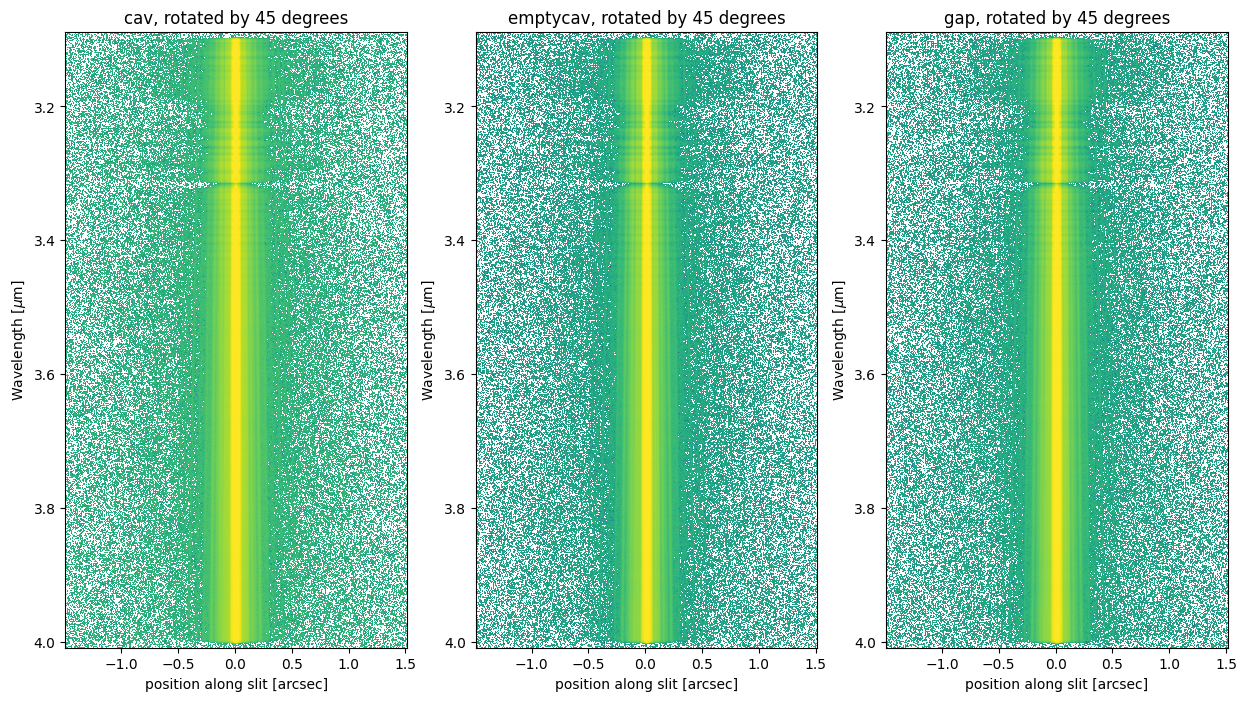

In [29]:
plt.figure(figsize=(15, 8))
for i, (model, result) in enumerate(rotresults.items()):
    plt.subplot(1, 3, i+1)
    plt.imshow((result[1].data - bgresult[1].data)[jlim[0]:jlim[1], ilim[0]:ilim[1]], 
               origin='lower', norm=LogNorm(),
               extent=(xlim[0], xlim[1], ylim[0], ylim[1]), aspect='auto')
    plt.xlabel(r"position along slit [arcsec]")
    plt.ylabel(r"Wavelength [$\mu$m]")
    plt.title(model + ", rotated by " + str(angle) + " degrees")

In [ ]:
for i, (model, result) in enumerate(rotresults.items()):
    outfile = Path(fitsfiles[model]).stem + "-rot_" + str(angle) + "-simulated_LSS_L" + Path(fitsfiles[model]).suffix
    result.writeto(outfile, overwrite=True)
    print(fitsfiles[model], "--->", outfile)

We compare the rotated spectrum for the `emptycav` model to the spectrum without rotation.

Text(0, 0.5, 'arcsec')

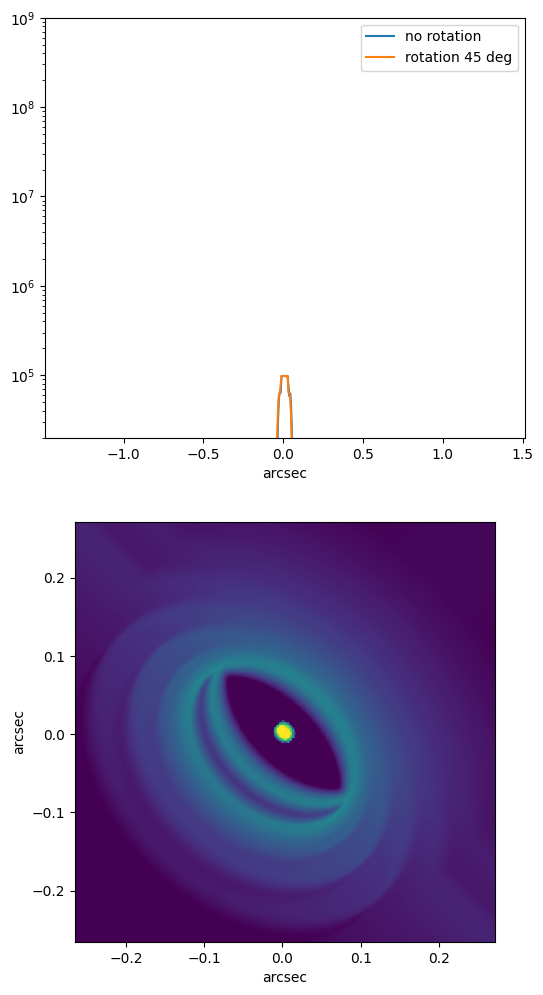

In [31]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 12))

ax1.plot(det_xi, (results['emptycav'][1].data - bgresult[1].data)[500, :], label="no rotation")
ax1.plot(det_xi, (rotresults['emptycav'][1].data - bgresult[1].data)[500, :], label=f"rotation {angle} deg")
ax1.set_xlim(xlim[0], xlim[-1])
ax1.set_ylim(2e4, 1e9)
ax1.set_xlabel("arcsec")
ax1.semilogy()
ax1.legend()

fig.subplots_adjust(left=0.1)
ax2.imshow(rotsources['emptycav'].cube_fields[0].data.sum(axis=0) + 1e-14, norm=LogNorm(vmin=1e-4, vmax=10),
           extent=(x_lim[0], x_lim[-1], y_lim[0], y_lim[-1]))
ax2.set_xlabel("arcsec")
ax2.set_ylabel("arcsec")

# Flux calibration

The pixel values in the detector images give electrons accumulated over the exposure time. To get back to physical units, e.g. Jy, one has to perform a flux calibration. As in real observations, we do this here with the observational of a standard star. For simplicity, we use a star with a spectrum that is constant at $f_{\nu} = 1\,\mathrm{Jy}$. We observe it with the identical setup as the science targets above, except that the exposure time is reduced to 1 second.

In [32]:
std = sim.source.source_templates.star(flux=1 * u.Jy)

In [33]:
metis.observe(std, update=True)

 FOV effects:  50%|███████████████████████████████████                                   | 1/2 [00:05<00:05,  5.64s/it]

astar.scopesim.effects.spectral_trace_list_utils - Mapping METIS LSS L



 FOVs: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:15<00:00, 15.58s/it]
 Image Plane effects: 0it [00:00, ?it/s]


In [34]:
std_exptime = 1  # second
std_result = metis.readout(exptime=std_exptime, detector_readout_mode='auto')[0]

astar.scopesim.effects.electronic - Detector mode set to fast
astar.scopesim.detector.detector_array - Extracting from 1 detectors...
astar.scopesim.effects.electronic - Detector mode set to fast


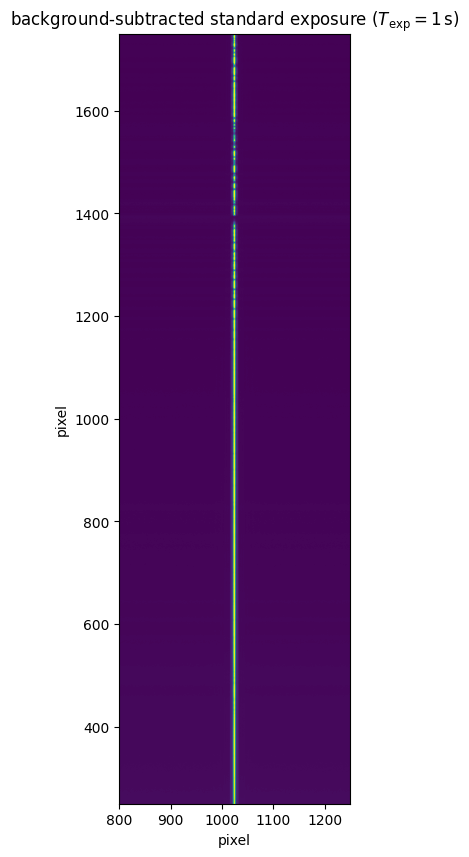

In [35]:
std_bgsub = std_result[1].data - bgresult[1].data / exptime

plt.figure(figsize=(10, 10))
plt.imshow(std_bgsub[250:1750, 800:1250], origin='lower', extent=(800, 1250, 250, 1750))
plt.xlabel('pixel')
plt.ylabel('pixel')
plt.title(r"background-subtracted standard exposure ($T_\mathrm{exp} = 1\,\mathrm{s}$)");

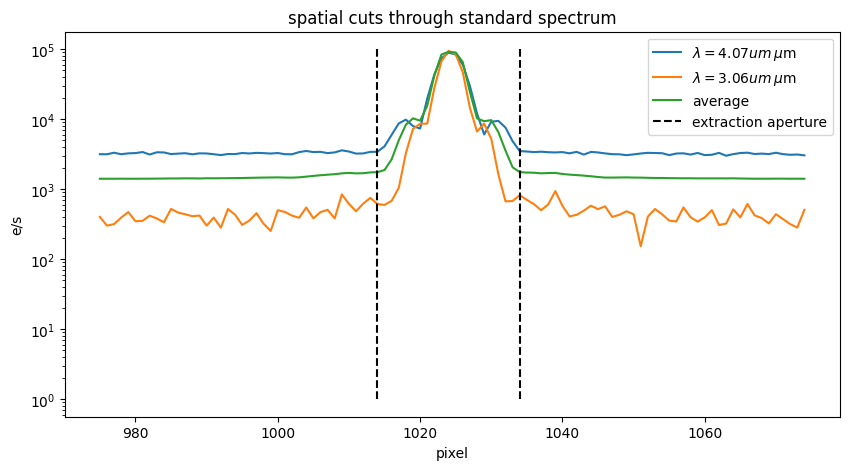

In [36]:
xmin, xmax = 975, 1075
xaxis = np.arange(xmin, xmax)
y_1, y_2 = 200, 1800
lam_1, lam_2 = det_wave[y_1], det_wave[y_2]

plt.figure(figsize=(10, 5))
plt.plot(xaxis, std_bgsub[200, xmin:xmax], label=fr"$\lambda = {lam_1:.2f}\,\mu\mathrm{{m}}$")
plt.plot(xaxis, std_bgsub[1800, xmin:xmax], label=fr"$\lambda = {lam_2:.2f}\,\mu\mathrm{{m}}$")
plt.plot(xaxis, std_bgsub[:, xmin:xmax].mean(axis=0), label='average')
plt.vlines((1024 - 10, 1024 + 10), 1, 1e5, colors='black', linestyles='dashed', label='extraction aperture')
plt.xlabel("pixel")
plt.ylabel("e/s")
plt.semilogy()
plt.legend()
plt.title("spatial cuts through standard spectrum");

The total flux density of 1 Jy from the star is spread over the point spread function, which extends far from the central position. It is cut by the finite aperture of the spectroscopic slit, and will be cut further by the finite extent of the extraction aperture over which we will sum the two-dimensional spectrum. Most of the flux is contained in the core of the PSF; from the figure, we can take an aperture size in the spatial direction of 20 pixels - outside this aperture, the spectrum is dominated by noise.  
The slit that we used is

In [37]:
# TODO: This used to return "C-38_1". The headers are made ESO
#       Compliant, and not all headers have been replaced.
#       See https://github.com/AstarVienna/irdb/pull/146
# std_result[1].header['SLIT']

with a width of 38.1 mas, corresponding to 7 pixels. As this notebook focuses on the simulator rather than the data reduction, we neglect slit and aperture losses and assume that the signal integrated over 20 pixels in the spatial direction corresponds to the input flux density of 1 Jy. The error is on the order of 2 per cent. 

In [38]:
hwidth = 10     # pixels, half width of extraction aperture
std_1d = std_bgsub[:, 1024-hwidth:1024+hwidth].sum(axis=1)

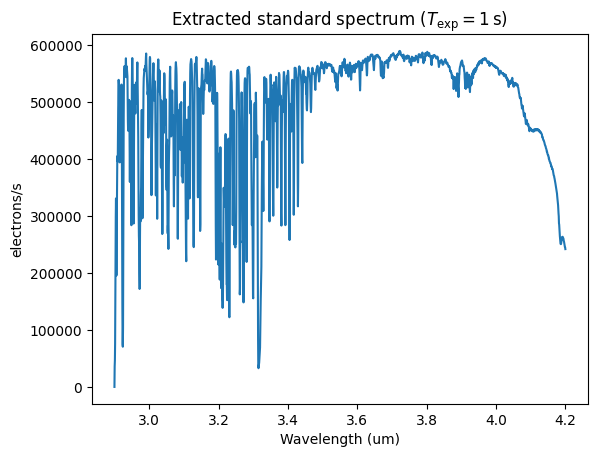

In [39]:
plt.plot(det_wave, std_1d)
plt.xlabel('Wavelength (um)')
exptime = std_result[1].header['EXPTIME']
plt.ylabel('electrons/s')
plt.title(r"Extracted standard spectrum ($T_{\mathrm{exp}} = 1\,\mathrm{s}$)");

We construct the flux conversion curve that takes the observed spectrum to the calibrated spectrum in Jy. Note that there are strong excursions at the edge of the spectroscopic filter and at deep atmospheric absorption features. The object flux at these wavelengths is not recoverable.

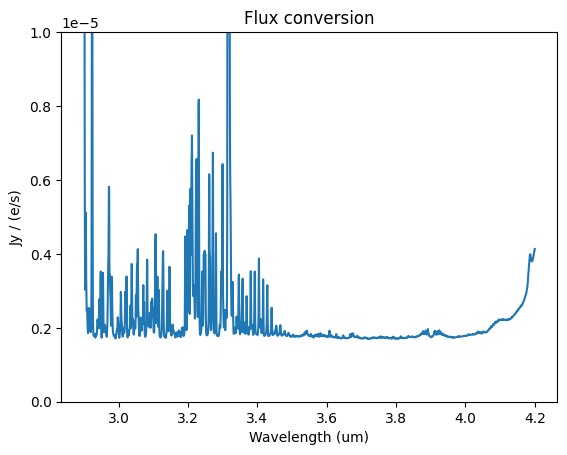

In [40]:
flux_conv = 1 * u.Jy / (std_1d * u.electron)
plt.plot(det_wave, flux_conv)
plt.ylim(0, 1e-5)
plt.xlabel("Wavelength (um)")
plt.ylabel("Jy / (e/s)")
plt.title("Flux conversion");

We apply the flux calibration to the two-dimensional spectra from above, taking into account the different exposure time, and display them. Note how the PAH feature at around 3.3 um now becomes apparent in the disk.

In [41]:
emptycav_Jy     = flux_conv[:, None] * (results['emptycav'][1].data - bgresult[1].data) / exptime
emptycav_Jy_rot = flux_conv[:, None] * (rotresults['emptycav'][1].data - bgresult[1].data) / exptime

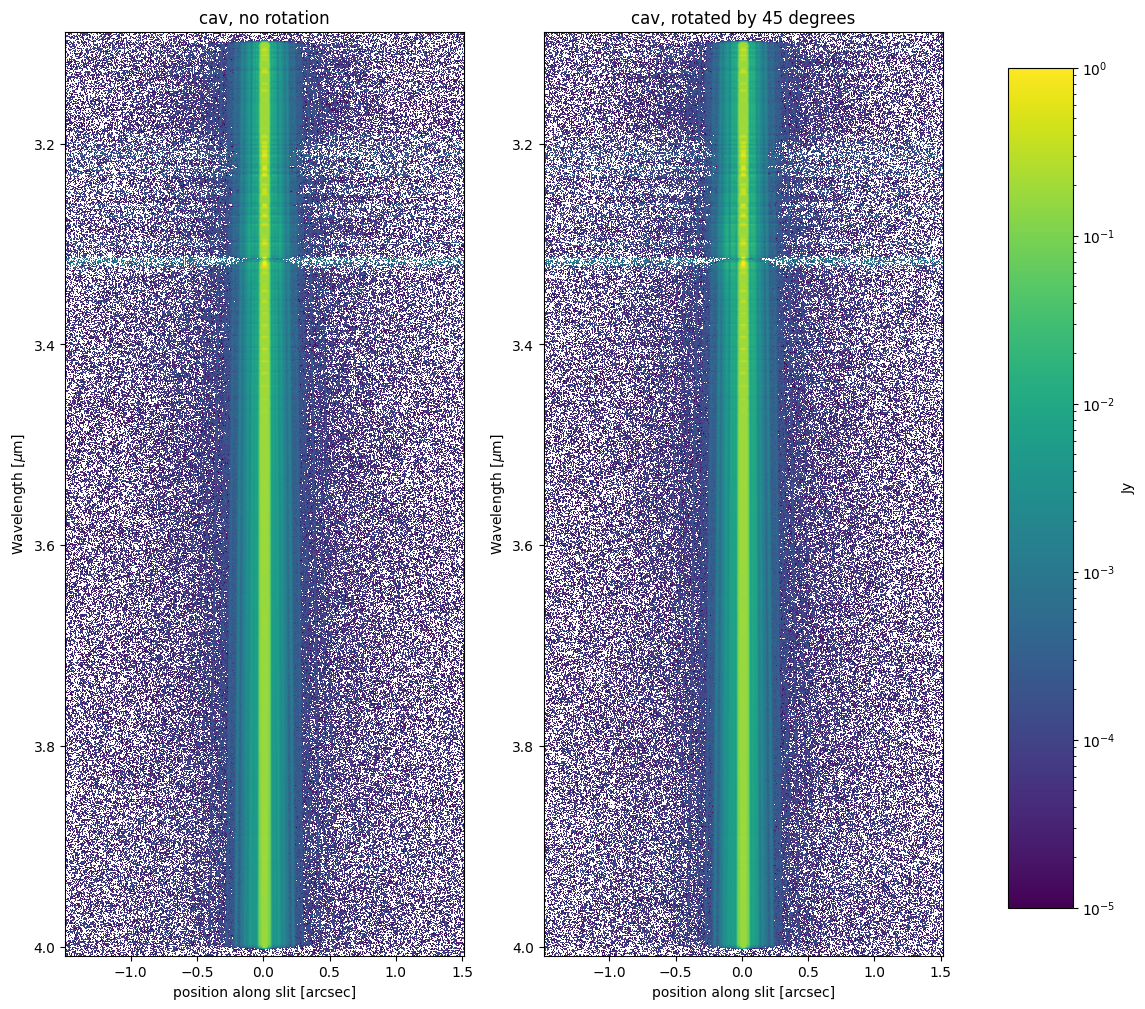

In [42]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 12))
ax1.imshow(emptycav_Jy[jlim[0]:jlim[1], ilim[0]:ilim[1]].value, origin='lower', 
           norm=LogNorm(vmin=1e-5, vmax=1), extent=(xlim[0], xlim[1], ylim[0], ylim[1]), aspect='auto')
ax1.set_xlabel(r"position along slit [arcsec]")
ax1.set_ylabel(r"Wavelength [$\mu$m]") 
ax1.set_title(model + ", no rotation")

img = ax2.imshow(emptycav_Jy_rot[jlim[0]:jlim[1], ilim[0]:ilim[1]].value, origin='lower',
                 norm=LogNorm(vmin=1e-5, vmax=1), extent=(xlim[0], xlim[1], ylim[0], ylim[1]), aspect='auto')
ax2.set_xlabel(r"position along slit [arcsec]")
ax2.set_ylabel(r"Wavelength [$\mu$m]") 
ax2.set_title(model + ", rotated by " + str(angle) + " degrees");

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(img, cax=cbar_ax, label='Jy')

Finally, we perform background subtraction and flux calibration on all simulations. The data are now normalised to an exposure time of 1 second and therefore have units 'electrons per second'.

In [ ]:
for i, (model, result) in enumerate(results.items()):
    result[1].data = flux_conv[:, None].value * (result[1].data - bgresult[1].data) / exptime
    result[1].header['BUNIT'] = "e/s"
    outfile = (Path(fitsfiles[model]).stem + "-simulated_LSS_L-bgsub_fluxcal" 
               + Path(fitsfiles[model]).suffix)
    result.writeto(outfile, overwrite=True)
    print("--->", outfile)

for i, (model, result) in enumerate(rotresults.items()):
    result[1].data = flux_conv[:, None].value * (result[1].data - bgresult[1].data) / exptime
    result[1].header['BUNIT'] = "e/s"
    outfile = (Path(fitsfiles[model]).stem + "-rot_" + str(angle) 
               + "-simulated_LSS_L-bgsub_fluxcal" + Path(fitsfiles[model]).suffix)
    result.writeto(outfile, overwrite=True)
    print("--->", outfile)

# Comparison to input spectrum

In [44]:
result_extract = results['emptycav'][1].data[:, 1018:1030].sum(axis=1)

In [45]:
src_extract = sources['emptycav'].cube_fields[0].data[:, 88:91, 87:92].sum(axis=(1, 2))
src_wave = sources['emptycav'].cube_fields[0].wave

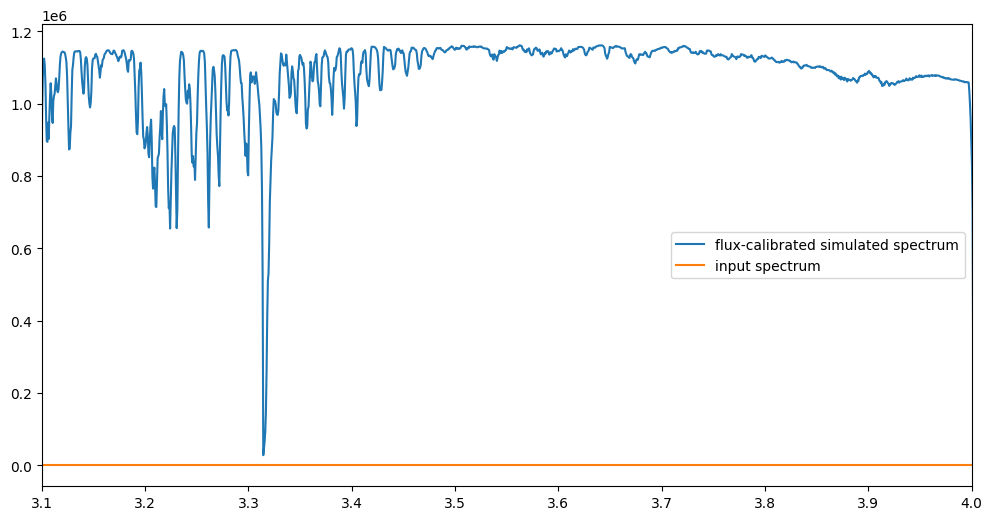

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(det_wave, result_extract, label="flux-calibrated simulated spectrum")
plt.plot(src_wave, src_extract, label="input spectrum")
plt.legend()
plt.xlim(3.1, 4.0);